In [1]:
    # from google.colab import drive
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
import optuna
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# drive.mount('/content/gdrive/')
# dir_path = '/content/gdrive/MyDrive/Colab_Notebooks/MLWBD_Project/'
# sys.path.append(dir_path)

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
start_time = time.time()
complaints_cfpb = pd. DataFrame()

for chunk in pd.read_csv('complaints.csv', chunksize=400000):
    print('Number of chunks read: ', chunk.shape)
    complaints_cfpb = pd.concat([complaints_cfpb, chunk])

print("Time taken to read the data: ", time.time() - start_time)

print("Shape of the dataframe: ", complaints_cfpb.shape)

Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (335939, 18)
Time taken to read the data:  35.38006782531738
Shape of the dataframe:  (6335939, 18)


In [6]:
complaints_cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2024-07-27,Credit card,General-purpose credit card or charge card,Getting a credit card,Card opened without my consent or knowledge,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,94519,NaN,Consent not provided,Web,2024-07-27,Closed with non-monetary relief,Yes,NaN,9634839
1,2024-09-18,Credit reporting or other personal consumer re...,Other personal consumer report,Incorrect information on your report,Information belongs to someone else,NaN,NaN,ENCORE CAPITAL GROUP INC.,FL,34472,NaN,NaN,Web,2024-09-18,Closed with explanation,Yes,NaN,10169554
2,2024-09-19,Student loan,Private student loan,Struggling to repay your loan,Bankruptcy,NaN,NaN,CL Holdings LLC,KY,40160,NaN,NaN,Web,2024-09-19,In progress,Yes,NaN,10169752
3,2024-06-09,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,I recently reviewed a copy of my credit report...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91730,NaN,Consent provided,Web,2024-06-09,Closed with non-monetary relief,Yes,NaN,9213312
4,2024-07-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,"To Whom It May Concern, I am writing in respon...",NaN,TrueAccord Corp.,TX,761XX,NaN,Consent provided,Web,2024-07-24,Closed with explanation,Yes,NaN,9592293


In [7]:
complaints_cfpb.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335939 entries, 0 to 6335938
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 8.3 

In [8]:
complaints_cfpb['Date received'] = pd.to_datetime(complaints_cfpb['Date received'], errors='coerce')
complaints_cfpb['Date sent to company'] = pd.to_datetime(complaints_cfpb['Date sent to company'], errors='coerce')
complaints_cfpb['Time_Duration'] = (complaints_cfpb['Date sent to company'] - complaints_cfpb['Date received']).dt.days

In [9]:
for col in complaints_cfpb.select_dtypes(include='object').columns:
    complaints_cfpb[col] = complaints_cfpb[col].astype('category')

In [10]:
def check_col_null_distribution(df):
    total_rows = df.shape[0]
    columns_with_null = df.columns[df.isnull().any()]

    null_percentages = {}

    for col in columns_with_null:
        null_count = df[col].isnull().sum()
        null_percentage = (null_count / total_rows) * 100
        null_percentages[col] = null_percentage

    return null_percentages

In [11]:
def plot_null_percentage(df):
    null_percentages = check_col_null_distribution(df)

    columns_with_null = list(null_percentages.keys())
    percentages = list(null_percentages.values())

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=columns_with_null, y=percentages, palette='viridis')

    plt.xticks(rotation=90)

    for i, p in enumerate(ax.patches):
        ax.annotate(f'{percentages[i]:.2f}%',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of missing values')
    plt.xlabel('Columns')
    plt.title('Percentage of missing values in each column')
    plt.show()

In [12]:
# See the range of dates in the dataset
print("Minimum date in the dataset: ", complaints_cfpb['Date received'].min())
print("Maximum date in the dataset: ", complaints_cfpb['Date received'].max())

# Subset the data ro include only the data after 01/01/2020
complaints_cfpb = complaints_cfpb[complaints_cfpb['Date received'] >= '2023-01-01']

Minimum date in the dataset:  2011-12-01 00:00:00
Maximum date in the dataset:  2024-10-06 00:00:00


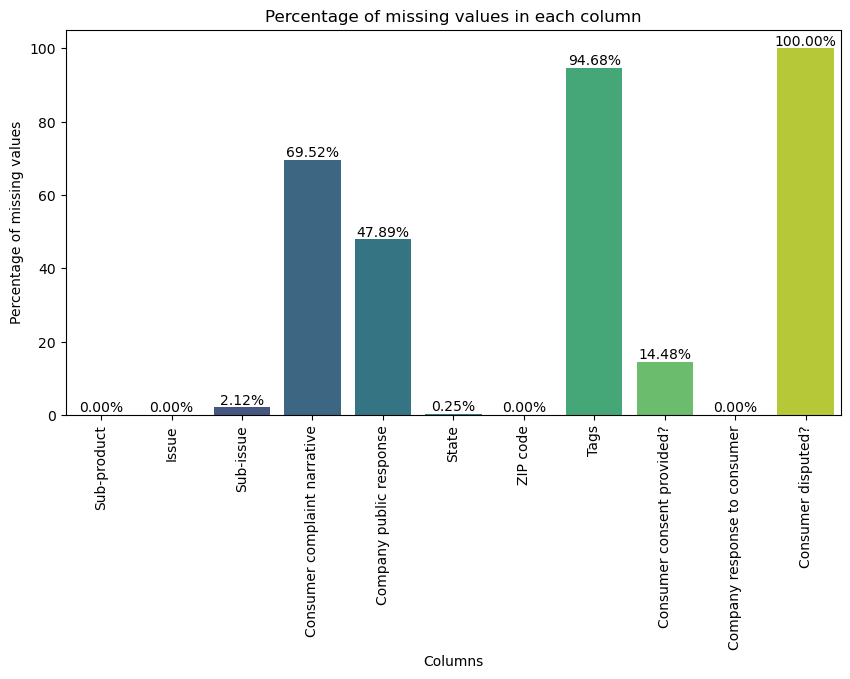

In [13]:
plot_null_percentage(complaints_cfpb)

In [14]:
columns_to_retain = ['Product', 'Issue', 'Company response to consumer', 'Sub-product', 'Sub-issue', 'State', 'ZIP code']

# columns_to_drop = ['Consumer complaint narrative', 'Tags', 'Consumer consent provided?', 'Consumer disputed?', 'Date received', 'Date sent to company']

In [15]:
# complaints_cfpb.drop(columns=columns_to_drop, axis=1, inplace=True)

In [16]:
complaints_cfpb['Sub-product'] = complaints_cfpb['Sub-product'].cat.add_categories("None").fillna("None")
complaints_cfpb['Sub-issue'] = complaints_cfpb['Sub-issue'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['Company response to consumer'] = complaints_cfpb['Company response to consumer'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['Company public response'] = complaints_cfpb['Company public response'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['State'] = complaints_cfpb['State'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['ZIP code'] = complaints_cfpb['ZIP code'].cat.add_categories("Not Provided").fillna("Not Provided")

In [17]:
complaints_cfpb.shape

(3121960, 19)

In [18]:
complaints_cfpb.isnull().sum()

Date received                         0
Product                               0
Sub-product                           0
Issue                                 6
Sub-issue                             0
Consumer complaint narrative    2170276
Company public response               0
Company                               0
State                                 0
ZIP code                              0
Tags                            2955953
Consumer consent provided?       451945
Submitted via                         0
Date sent to company                  0
Company response to consumer          0
Timely response?                      0
Consumer disputed?              3121960
Complaint ID                          0
Time_Duration                         0
dtype: int64

In [19]:
categorical_cols = ['Sub-product', 'Issue', 'Sub-issue', 'State', 'Submitted via']
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
encoded_data = encoder.fit_transform(complaints_cfpb[categorical_cols])

encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

encoded_df.index = complaints_cfpb.index

complaints_cfpb = pd.concat([complaints_cfpb.drop(categorical_cols, axis=1), encoded_df], axis=1)

In [20]:
complaints_cfpb.shape

(3121960, 447)

In [21]:
complaints_cfpb.head()

,Date received,Product,Consumer complaint narrative,Company public response,Company,ZIP code,Tags,Consumer consent provided?,Date sent to company,Company response to consumer,...,State_WA,State_WI,State_WV,State_WY,Submitted via_Email,Submitted via_Phone,Submitted via_Postal mail,Submitted via_Referral,Submitted via_Web,Submitted via_Web Referral
0,2024-07-27,Credit card,NaN,Unknown,CAPITAL ONE FINANCIAL CORPORATION,94519,NaN,Consent not provided,2024-07-27,Closed with non-monetary relief,...,0,0,0,0,0,0,0,0,1.00,0
1,2024-09-18,Credit reporting or other personal consumer re...,NaN,Unknown,ENCORE CAPITAL GROUP INC.,34472,NaN,NaN,2024-09-18,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0
2,2024-09-19,Student loan,NaN,Unknown,CL Holdings LLC,40160,NaN,NaN,2024-09-19,In progress,...,0,0,0,0,0,0,0,0,1.00,0
3,2024-06-09,Credit reporting or other personal consumer re...,I recently reviewed a copy of my credit report...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,91730,NaN,Consent provided,2024-06-09,Closed with non-monetary relief,...,0,0,0,0,0,0,0,0,1.00,0
4,2024-07-24,Credit reporting or other personal consumer re...,"To Whom It May Concern, I am writing in respon...",Unknown,TrueAccord Corp.,761XX,NaN,Consent provided,2024-07-24,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0


In [22]:
complaints_cfpb["Product"].value_counts().sum()

3121960

In [23]:
def combine_product_categories(df):
    # Get value counts of the Product column
    product_counts = df["Product"].value_counts()

    # Define mappings for categories to combine
    category_mappings = {
        0: [
            "Credit reporting or other personal consumer reports",
            "Credit reporting, credit repair services, or other personal consumer reports",
            "Credit reporting",
            "Credit card",
            "Credit card or prepaid card",
            "Prepaid card",
            "Debt or credit management"
        ],
        1: [
            "Debt collection",
            "Mortgage",
            "Vehicle loan or lease",
            "Student loan",
            "Payday loan, title loan, personal loan, or advance loan",
            "Payday loan, title loan, or personal loan",
            "Payday loan",
            "Consumer Loan"
        ],
        2: [
            "Checking or savings account",
            "Bank account or service",
            "Money transfer, virtual currency, or money service",
            "Money transfers",
            "Virtual currency"
        ]
    }

    # Combine categories
    product_to_category = {}
    for category, products in category_mappings.items():
        for product in products:
            product_to_category[product] = category

    # Apply the mapping to create a new column with combined categories
    df['Product'] = df['Product'].map(product_to_category)

    # Fill any unmapped categories with -1 (or any other value you prefer for 'Other')
    df['Product'] = df['Product'].fillna(-1)

    # Convert to integer type
    df['Product'] = df['Product'].astype(int)

    # Print value counts of the new combined categories
    print(df['Product'].value_counts().sort_index())

    return df['Product']


In [24]:
combine_product_categories(complaints_cfpb)
complaints_cfpb["Product"].value_counts().sum()

Product
0    2743720
1     266256
2     111984
Name: count, dtype: int64


3121960

In [25]:
complaints_cfpb["Timely response?"].value_counts().sum()

3121960

In [26]:
complaints_cfpb.columns

Index(['Date received', 'Product', 'Consumer complaint narrative',
       'Company public response', 'Company', 'ZIP code', 'Tags',
       'Consumer consent provided?', 'Date sent to company',
       'Company response to consumer',
       ...
       'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Submitted via_Email',
       'Submitted via_Phone', 'Submitted via_Postal mail',
       'Submitted via_Referral', 'Submitted via_Web',
       'Submitted via_Web Referral'],
      dtype='object', length=447)

In [27]:
complaints_cfpb.drop('Complaint ID', axis=1)

,Date received,Product,Consumer complaint narrative,Company public response,Company,ZIP code,Tags,Consumer consent provided?,Date sent to company,Company response to consumer,...,State_WA,State_WI,State_WV,State_WY,Submitted via_Email,Submitted via_Phone,Submitted via_Postal mail,Submitted via_Referral,Submitted via_Web,Submitted via_Web Referral
0,2024-07-27,0,NaN,Unknown,CAPITAL ONE FINANCIAL CORPORATION,94519,NaN,Consent not provided,2024-07-27,Closed with non-monetary relief,...,0,0,0,0,0,0,0,0,1.00,0
1,2024-09-18,0,NaN,Unknown,ENCORE CAPITAL GROUP INC.,34472,NaN,NaN,2024-09-18,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0
2,2024-09-19,1,NaN,Unknown,CL Holdings LLC,40160,NaN,NaN,2024-09-19,In progress,...,0,0,0,0,0,0,0,0,1.00,0
3,2024-06-09,0,I recently reviewed a copy of my credit report...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,91730,NaN,Consent provided,2024-06-09,Closed with non-monetary relief,...,0,0,0,0,0,0,0,0,1.00,0
4,2024-07-24,0,"To Whom It May Concern, I am writing in respon...",Unknown,TrueAccord Corp.,761XX,NaN,Consent provided,2024-07-24,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330917,2023-03-19,2,"Hello, PayPal team, I received an email notifi...",Unknown,"Paypal Holdings, Inc",78640,NaN,Consent provided,2023-03-19,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0
6331032,2023-01-24,2,Company : PayPal Service : Paypal Reference : ...,Unknown,"Paypal Holdings, Inc",XXXXX,NaN,Consent provided,2023-01-24,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0
6331119,2023-02-22,0,On XX/XX/XXXX I used my credit card to make a ...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,91104,NaN,Consent provided,2023-03-02,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0
6331475,2023-03-19,0,NaN,Unknown,"CBC Companies, Inc.",21202,NaN,Consent not provided,2023-03-19,Closed with explanation,...,0,0,0,0,0,0,0,0,1.00,0


In [28]:
label_encoder = LabelEncoder()
complaints_cfpb['Timely response?_encoded'] = label_encoder.fit_transform(complaints_cfpb['Timely response?'])

In [29]:
# Identify numeric columns
numeric_columns = complaints_cfpb.select_dtypes(include=['int64', 'float64', 'bool']).columns

print(numeric_columns)

# Use only numeric columns for feature selection
X = complaints_cfpb[numeric_columns].drop('Timely response?_encoded', axis=1)
y = complaints_cfpb['Timely response?_encoded']

# Now perform feature selection
k = 400  # Adjust as needed
selector = SelectKBest(score_func=chi2, k=k)
# X_reduced = selector.fit_transform(X, y)
# y_reduced = y

Index(['Product', 'Complaint ID', 'Time_Duration', 'Sub-product_Auto debt',
       'Sub-product_CD (Certificate of Deposit)',
       'Sub-product_Check cashing service', 'Sub-product_Checking account',
       'Sub-product_Conventional home mortgage',
       'Sub-product_Credit card debt', 'Sub-product_Credit repair services',
       ...
       'State_WI', 'State_WV', 'State_WY', 'Submitted via_Email',
       'Submitted via_Phone', 'Submitted via_Postal mail',
       'Submitted via_Referral', 'Submitted via_Web',
       'Submitted via_Web Referral', 'Timely response?_encoded'],
      dtype='object', length=437)


In [30]:
#Temporary Selection
X_reduced_sample = selector.fit_transform(X, y)
# X_reduced_sample_df = pd.DataFrame(X_reduced_sample)
# X_reduced = X_reduced_sample_df.sample(n=900000, random_state=42)
# y_reduced = y[:900000]
X_reduced = X_reduced_sample
y_reduced = y

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(selected_features)

# print("Shape before SMOTE:", X_reduced.shape)

Index(['Product', 'Complaint ID', 'Time_Duration', 'Sub-product_Auto debt',
       'Sub-product_CD (Certificate of Deposit)',
       'Sub-product_Check cashing service', 'Sub-product_Checking account',
       'Sub-product_Conventional home mortgage',
       'Sub-product_Credit card debt', 'Sub-product_Credit repair services',
       ...
       'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY',
       'Submitted via_Phone', 'Submitted via_Postal mail',
       'Submitted via_Referral', 'Submitted via_Web',
       'Submitted via_Web Referral'],
      dtype='object', length=400)


In [31]:
def prepare_data(X, y, target_column):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train
    print(f"Model training time: {train_time:.3f} seconds")

    # Make predictions
    start_predict = time.time()
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    end_predict = time.time()
    predict_time = end_predict - start_predict
    print(f"Prediction time: {predict_time:.3f} seconds")

    # Calculate and print metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    return model

In [32]:
# # Apply SMOTE to balance the dataset
# smote = SMOTE(random_state=42)
# X_balanced, y_balanced = smote.fit_resample(X_reduced, y_reduced)

# print("Shape after SMOTE:", X_balanced.shape)
# print("Class distribution after SMOTE:", pd.Series(y_balanced).value_counts(normalize=True))

# Apply NearMiss to balance the dataset
start_predict = time.time()
nearmiss = NearMiss(version=1, n_neighbors=3)
X_balanced, y_balanced = nearmiss.fit_resample(X_reduced, y_reduced)
end_predict = time.time()
process_time = end_predict - start_predict
print("Shape after NearMiss:", X_balanced.shape)
print("Class distribution after NearMiss:", pd.Series(y_balanced).value_counts(normalize=True))
print(f"Time to process: {process_time:.3f} seconds")

#strat_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# # Split the data
# for train_index, test_index in strat_kfold.split(X_reduced, y_reduced):
#     # Split into training and validation sets
#     X_train, X_test = X_reduced[train_index], X_reduced[test_index]
#     y_train, y_test = y_reduced[train_index], y_reduced[test_index]
#     break

# # Split the data
# for train_index, test_index in strat_kfold.split(X_reduced, y_reduced):
#     # Split into training and validation sets
#     X_train = X_reduced.iloc[train_index]
#     X_test = X_reduced.iloc[test_index]
#     y_train = y_reduced.iloc[train_index] if isinstance(y_reduced, pd.Series) else y_reduced[train_index]
#     y_test = y_reduced.iloc[test_index] if isinstance(y_reduced, pd.Series) else y_reduced[test_index]
#     break

# print("Shape of training set:", X_train.shape)
# print("Shape of test set:", X_test.shape)

Shape after NearMiss: (22110, 400)
Class distribution after NearMiss: Timely response?_encoded
0   0.50
1   0.50
Name: proportion, dtype: float64
Time to process: 155.121 seconds


In [33]:
# Prepare the data
X_train, X_test, y_train, y_test = prepare_data(X_balanced, y_balanced, 'Timely response?_encoded')

Model training time: 0.329 seconds
Prediction time: 0.007 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82      2242
           1       0.79      0.86      0.83      2180

    accuracy                           0.82      4422
   macro avg       0.82      0.82      0.82      4422
weighted avg       0.82      0.82      0.82      4422

Accuracy: 0.8204
Precision: 0.8227
Recall: 0.8204
F1-score: 0.8203


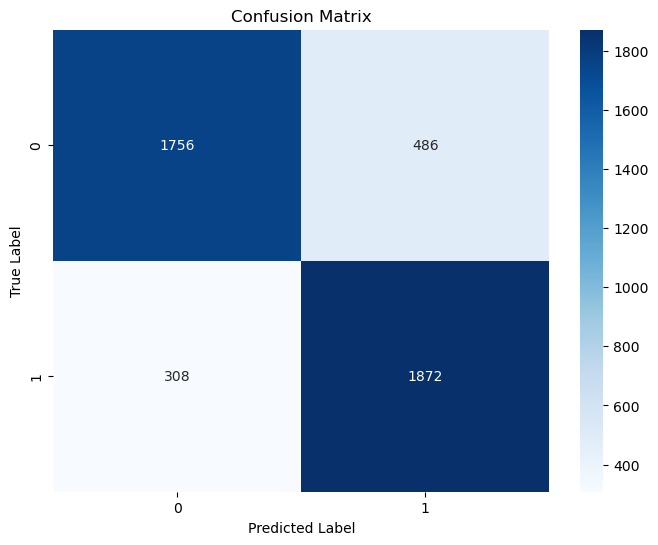

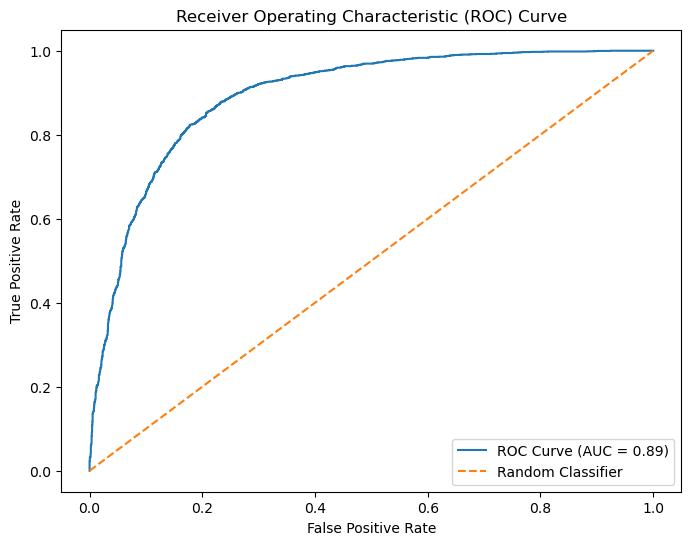

In [34]:
# Initialize the XGBoost model
# xgb_model = XGBClassifier(num_class = 2, objective="multi:softprob", eval_metric="mlogloss", seed=42)

xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="logloss", seed=42)

# Train and evaluate the XGBoost model
best_xgb_model = train_evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 17688, number of used features: 231
[LightGBM] [Info] Start training from score -0.696659
[LightGBM] [Info] Start training from score -0.689648
[LightGBM] [Info] Start training from score -34.538776
Model training time: 0.609 seconds
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will b

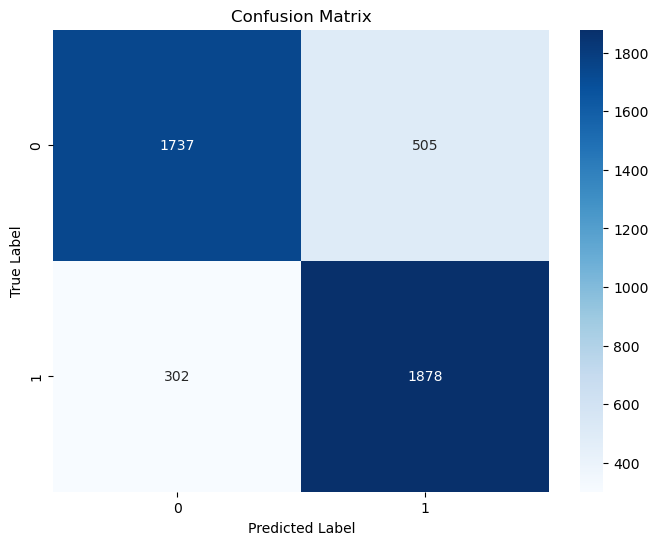

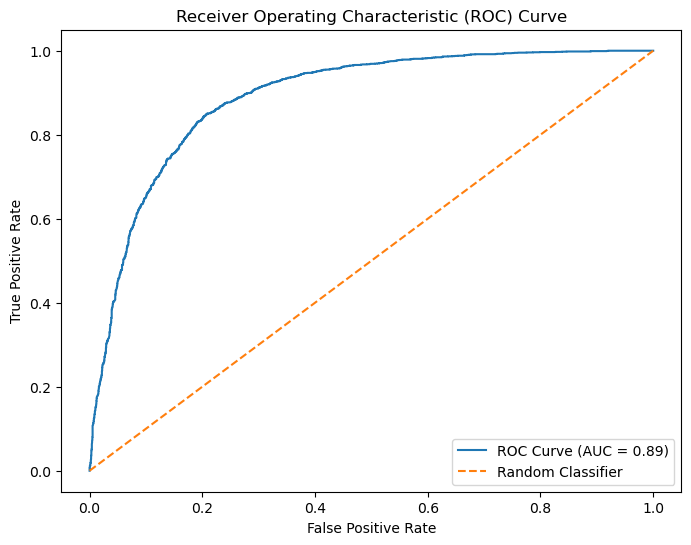

In [35]:
params = {
'objective': 'multiclass',
'boosting_type': 'gbdt',
'num_leaves': 31,
'learning_rate': 0.05,
'feature_fraction': 0.9,
'num_class': 3
}

# Initialize the LightGBM model
lgbm_model = LGBMClassifier(**params, n_jobs=-1, seed=42) 

# Train and evaluate the LightGBM model
best_lgbm_model = train_evaluate_model(lgbm_model, X_train, X_test, y_train, y_test)

Model training time: 1.149 seconds
Prediction time: 0.005 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      2242
           1       0.76      0.84      0.80      2180

    accuracy                           0.79      4422
   macro avg       0.79      0.79      0.79      4422
weighted avg       0.79      0.79      0.79      4422

Accuracy: 0.7904
Precision: 0.7939
Recall: 0.7904
F1-score: 0.7899


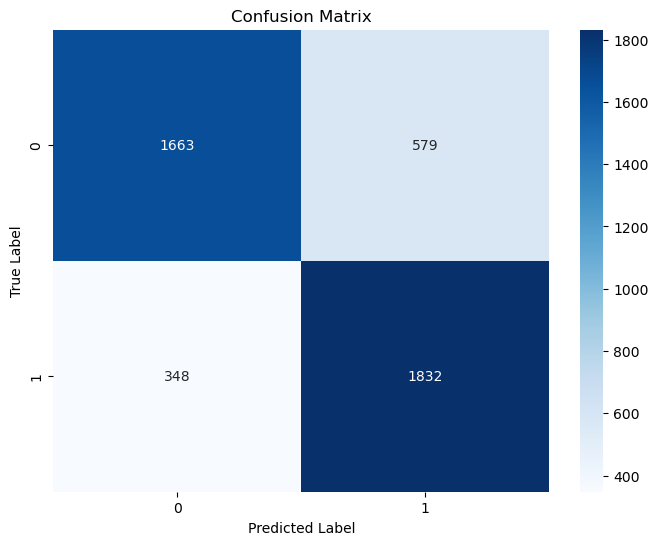

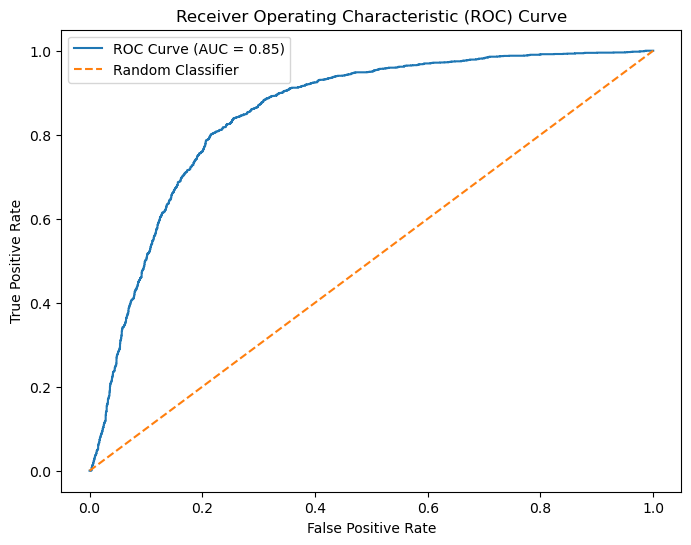

In [36]:
# Define the parameter grid for Logistic Regression
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'max_iter': [100, 500, 1000],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'saga']
}

# Initialize the Logistic Regression model
lr_model = LogisticRegression(n_jobs=-1, random_state=42)

# Prepare the data
scaler = StandardScaler()
X_balanced_scaled = scaler.fit_transform(X_balanced)
X_train_1, X_test_1, y_train_1, y_test_1 = prepare_data(X_balanced_scaled, y_balanced, 'Product')

# Train and evaluate the Logistic Regression model
best_lr_model = train_evaluate_model(lr_model, X_train_1, X_test_1, y_train_1, y_test_1)

Model training time: 0.539 seconds
Prediction time: 0.054 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2242
           1       0.79      0.75      0.77      2180

    accuracy                           0.78      4422
   macro avg       0.78      0.78      0.78      4422
weighted avg       0.78      0.78      0.78      4422

Accuracy: 0.7802
Precision: 0.7808
Recall: 0.7802
F1-score: 0.7800


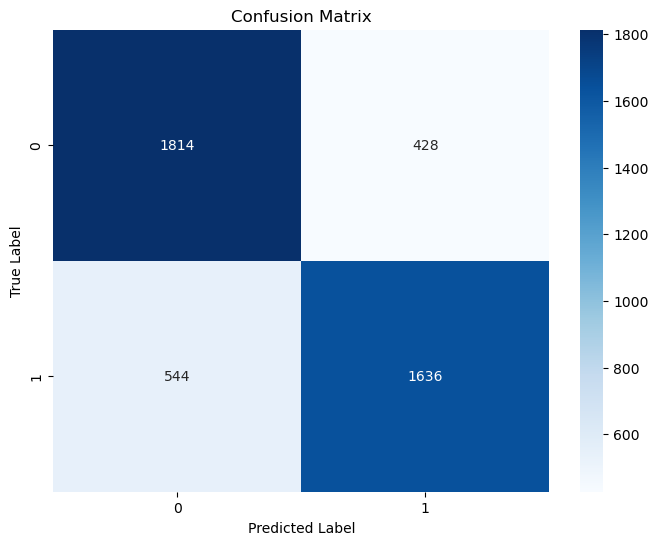

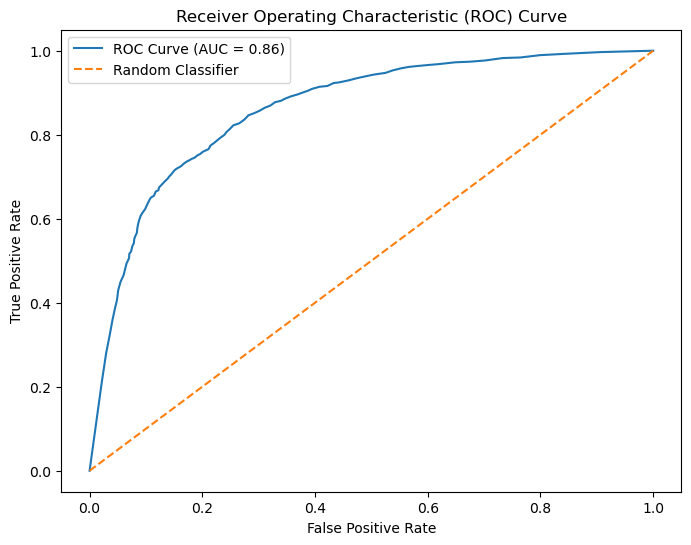

In [37]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_jobs = -1, random_state=42)

# Train and evaluate the Random Forest model
best_rf_model = train_evaluate_model(rf_model, X_train, X_test, y_train, y_test)

Model training time: 0.243 seconds
Prediction time: 0.004 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2242
           1       0.80      0.83      0.82      2180

    accuracy                           0.82      4422
   macro avg       0.82      0.82      0.82      4422
weighted avg       0.82      0.82      0.82      4422

Accuracy: 0.8157
Precision: 0.8160
Recall: 0.8157
F1-score: 0.8157


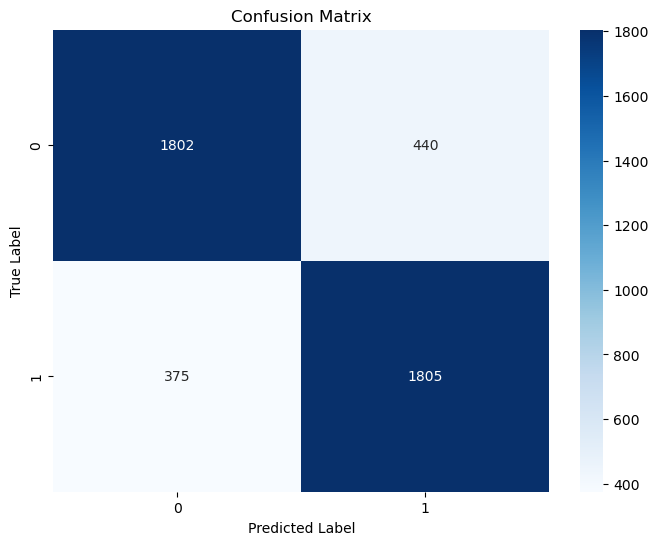

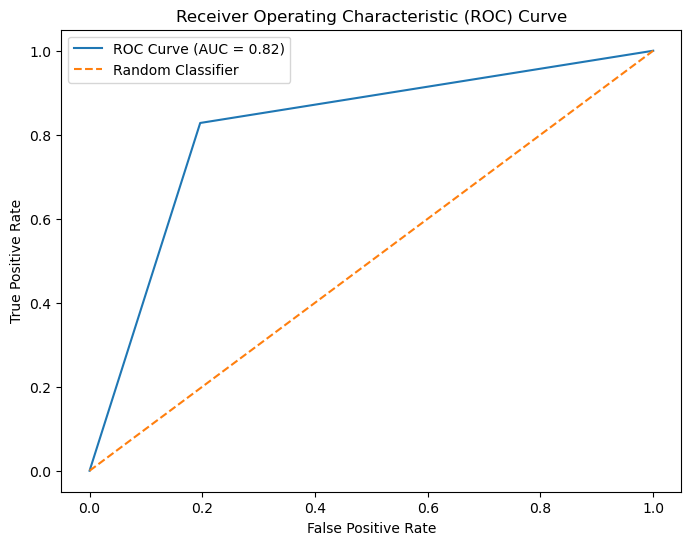

In [38]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train and evaluate the Decision Tree model
best_dt_model = train_evaluate_model(dt_model, X_train, X_test, y_train, y_test)

In [39]:
# Create the VotingClassifier
start_train = time.time()
voting_clf = VotingClassifier(estimators=[('rf', rf_model), ('lr', lr_model), ('dt', dt_model), ('xgb', xgb_model), ('lgbm', lgbm_model)], voting='hard')

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)
end_train = time.time()
train_time = end_train - start_train

print(f"Model execution time: {train_time:.3f} seconds")

# Make predictions
predictions = voting_clf.predict(X_test)

# Evaluate the model
accuracy = voting_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")    

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 17688, number of used features: 231
[LightGBM] [Info] Start training from score -0.696659
[LightGBM] [Info] Start training from score -0.689648
[LightGBM] [Info] Start training from score -34.538776
Model execution time: 1.843 seconds
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will 

In [40]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)

    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return score.mean()

def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 1, 16)  # -1 means no limit
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0)
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 100)

    model = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        random_state=42
    )

    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return score.mean()

def objective_lr(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1.0)
    model = LogisticRegression(C=C, random_state=42)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return score.mean()

def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return score.mean()

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                   min_samples_split=min_samples_split, random_state=42)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5)
    return score.mean()


def create_study(model_name, objective):
    print(f"Creating study for {model_name} model")
    start_predict = time.time()
    study_model = optuna.create_study(direction="maximize")
    study_model.optimize(objective, n_trials=15)
    end_predict = time.time()
    predict_time = end_predict - start_predict
    print(f"Study created for {model_name} model in {predict_time:.3f} seconds")
    return study_model

# Optimize XGB
study_xgb = create_study("XGB", objective_xgb)

# Optimize LGBM
study_lgbm = create_study("LGBM", objective_lgbm)

# Optimize Random Forest
study_rf = create_study("Random Forest", objective_rf)

# Optimize Logistic Regression
study_lr = create_study("Logistic Regression", objective_lr)

# Optimize Decision Tree
study_dt = create_study("Decision Tree", objective_dt)

[I 2024-12-10 18:27:30,033] A new study created in memory with name: no-name-cbd45b0a-f494-4a4a-a779-2026e627023b


Creating study for XGB model


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:27:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:27:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:27:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:27:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Study created for XGB model in 15.385 seconds
Creating study for LGBM model


[I 2024-12-10 18:27:47,173] Trial 0 finished with value: 0.804613363725123 and parameters: {'n_estimators': 22, 'max_depth': 9, 'learning_rate': 0.37230542350200324, 'num_leaves': 178, 'min_data_in_leaf': 69}. Best is trial 0 with value: 0.804613363725123.
[I 2024-12-10 18:27:48,394] Trial 1 finished with value: 0.5017526102561423 and parameters: {'n_estimators': 80, 'max_depth': 12, 'learning_rate': 4.487143628425055e-05, 'num_leaves': 12, 'min_data_in_leaf': 80}. Best is trial 0 with value: 0.804613363725123.


[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Info] Number of positive: 7100, number of negative: 7051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 531
[LightGBM] [Info] Number of data points in the train set: 14151, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501731 -> initscore=0.006925
[LightGBM] [Info] Start training from score 0.006925
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ig

[I 2024-12-10 18:27:49,777] Trial 2 finished with value: 0.7805858538493096 and parameters: {'n_estimators': 94, 'max_depth': 4, 'learning_rate': 0.0010649081775138537, 'num_leaves': 149, 'min_data_in_leaf': 34}. Best is trial 0 with value: 0.804613363725123.
[I 2024-12-10 18:27:54,445] Trial 3 finished with value: 0.8056309836433165 and parameters: {'n_estimators': 92, 'max_depth': 9, 'learning_rate': 0.06280521343858425, 'num_leaves': 112, 'min_data_in_leaf': 30}. Best is trial 3 with value: 0.8056309836433165.
[I 2024-12-10 18:27:56,029] Trial 4 finished with value: 0.8024084086934966 and parameters: {'n_estimators': 55, 'max_depth': 8, 'learning_rate': 0.14754515889313002, 'num_leaves': 61, 'min_data_in_leaf': 64}. Best is trial 3 with value: 0.8056309836433165.
[I 2024-12-10 18:27:57,374] Trial 5 finished with value: 0.8109453275420162 and parameters: {'n_estimators': 21, 'max_depth': 12, 'learning_rate': 0.48950682777721904, 'num_leaves': 25, 'min_data_in_leaf': 28}. Best is tria

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Info] Number of positive: 7100, number of negative: 7051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 14151, number of used features: 121
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501731 -> initscore=0.006925
[LightGBM] [Info] Start training from score 0.006925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-12-10 18:28:19,135] Trial 8 finished with value: 0.7847129265634567 and parameters: {'n_estimators': 95, 'max_depth': 14, 'learning_rate': 0.0006582851585831293, 'num_leaves': 199, 'min_data_in_leaf': 68}. Best is trial 5 with value: 0.8109453275420162.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Info] Number of positive: 7100, number of negative: 7050
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 14150, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501767 -> initscore=0.007067
[LightGBM] [Info] Start training from score 0.007067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-12-10 18:28:19,727] Trial 9 finished with value: 0.5017526102561423 and parameters: {'n_estimators': 30, 'max_depth': 4, 'learning_rate': 1.8484421353838825e-05, 'num_leaves': 165, 'min_data_in_leaf': 55}. Best is trial 5 with value: 0.8109453275420162.
[I 2024-12-10 18:28:22,631] Trial 10 finished with value: 0.7744796069268859 and parameters: {'n_estimators': 12, 'max_depth': 16, 'learning_rate': 0.966440321763684, 'num_leaves': 245, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.8109453275420162.
[I 2024-12-10 18:28:24,502] Trial 11 finished with value: 0.7858437005999566 and parameters: {'n_estimators': 71, 'max_depth': 8, 'learning_rate': 0.020548249353231435, 'num_leaves': 20, 'min_data_in_leaf': 31}. Best is trial 5 with value: 0.8109453275420162.
[I 2024-12-10 18:28:24,865] Trial 12 finished with value: 0.7596673972139474 and parameters: {'n_estimators': 40, 'max_depth': 1, 'learning_rate': 0.045323772612771755, 'num_leaves': 108, 'min_data_in_leaf': 12}. Best is

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 7100, number of negative: 7051
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 687
[LightGBM] [Info] Number of data points in the train set: 14151, number of used features: 185
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501731 -> initscore=0.006925
[LightGBM] [Info] Start training from score 0.006925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-12-10 18:28:29,505] Trial 14 finished with value: 0.8042172603821701 and parameters: {'n_estimators': 58, 'max_depth': 6, 'learning_rate': 0.15134148649300252, 'num_leaves': 122, 'min_data_in_leaf': 16}. Best is trial 5 with value: 0.8109453275420162.
[I 2024-12-10 18:28:29,506] A new study created in memory with name: no-name-c83922ff-3b76-461c-b6b8-11c730e2f60f


Study created for LGBM model in 44.088 seconds
Creating study for Random Forest model


[I 2024-12-10 18:28:32,521] Trial 0 finished with value: 0.7789462378892729 and parameters: {'n_estimators': 120, 'max_depth': 15, 'min_samples_split': 6}. Best is trial 0 with value: 0.7789462378892729.
[I 2024-12-10 18:28:35,531] Trial 1 finished with value: 0.7920625102985431 and parameters: {'n_estimators': 97, 'max_depth': 32, 'min_samples_split': 19}. Best is trial 1 with value: 0.7920625102985431.
[I 2024-12-10 18:28:39,138] Trial 2 finished with value: 0.7904794074687791 and parameters: {'n_estimators': 121, 'max_depth': 28, 'min_samples_split': 6}. Best is trial 1 with value: 0.7920625102985431.
[I 2024-12-10 18:28:42,872] Trial 3 finished with value: 0.7855041902983768 and parameters: {'n_estimators': 137, 'max_depth': 21, 'min_samples_split': 4}. Best is trial 1 with value: 0.7920625102985431.
[I 2024-12-10 18:28:43,439] Trial 4 finished with value: 0.7832995549111524 and parameters: {'n_estimators': 15, 'max_depth': 22, 'min_samples_split': 16}. Best is trial 1 with value: 

Study created for Random Forest model in 43.296 seconds
Creating study for Logistic Regression model


[I 2024-12-10 18:29:13,399] Trial 0 finished with value: 0.7639639134255922 and parameters: {'C': 0.0019552472993618836}. Best is trial 0 with value: 0.7639639134255922.
[I 2024-12-10 18:29:14,112] Trial 1 finished with value: 0.7657172908282993 and parameters: {'C': 0.003765478127604088}. Best is trial 1 with value: 0.7657172908282993.
[I 2024-12-10 18:29:14,693] Trial 2 finished with value: 0.7631171754047058 and parameters: {'C': 0.0012465938717516488}. Best is trial 1 with value: 0.7657172908282993.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 

Study created for Logistic Regression model in 11.030 seconds
Creating study for Decision Tree model


[I 2024-12-10 18:29:24,440] Trial 0 finished with value: 0.8107188914476422 and parameters: {'max_depth': 15, 'min_samples_split': 9}. Best is trial 0 with value: 0.8107188914476422.
[I 2024-12-10 18:29:24,995] Trial 1 finished with value: 0.8035391188011161 and parameters: {'max_depth': 12, 'min_samples_split': 7}. Best is trial 0 with value: 0.8107188914476422.
[I 2024-12-10 18:29:25,582] Trial 2 finished with value: 0.8133761273258726 and parameters: {'max_depth': 17, 'min_samples_split': 9}. Best is trial 2 with value: 0.8133761273258726.
[I 2024-12-10 18:29:26,158] Trial 3 finished with value: 0.8067047970473806 and parameters: {'max_depth': 13, 'min_samples_split': 20}. Best is trial 2 with value: 0.8133761273258726.
[I 2024-12-10 18:29:26,746] Trial 4 finished with value: 0.8147894989781767 and parameters: {'max_depth': 16, 'min_samples_split': 9}. Best is trial 4 with value: 0.8147894989781767.
[I 2024-12-10 18:29:27,548] Trial 5 finished with value: 0.8075525739125737 and para

Study created for Decision Tree model in 8.892 seconds



******************** Analysis for XGB ********************
Accuracy: 0.8181
Best hyperparameters: {'n_estimators': 70, 'max_depth': 14, 'learning_rate': 0.10797937994188747, 'subsample': 0.9456346565786333, 'colsample_bytree': 0.6438701345994625}


Re-training model with Best Params
Model training time: 0.405 seconds
Prediction time: 0.011 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      2242
           1       0.81      0.87      0.84      2180

    accuracy                           0.83      4422
   macro avg       0.83      0.83      0.83      4422
weighted avg       0.83      0.83      0.83      4422

Accuracy: 0.8318
Precision: 0.8337
Recall: 0.8318
F1-score: 0.8316


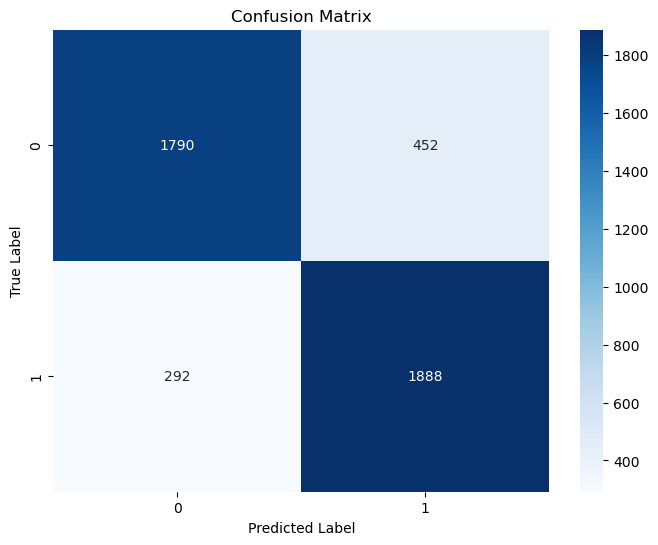

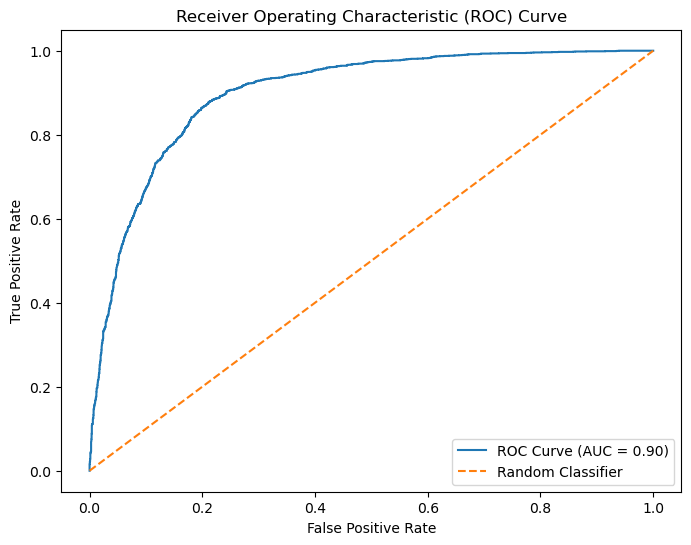


******************** Analysis for LGBM ********************
Accuracy: 0.8109
Best hyperparameters: {'n_estimators': 21, 'max_depth': 12, 'learning_rate': 0.48950682777721904, 'num_leaves': 25, 'min_data_in_leaf': 28}


Re-training model with Best Params
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Number of positive: 8875, number of negative: 8813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 17688, number of used features: 210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501753 -> initscore=0.007010


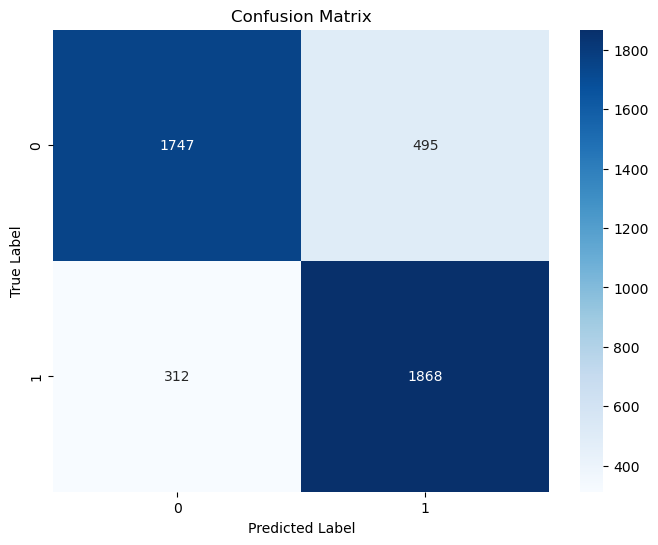

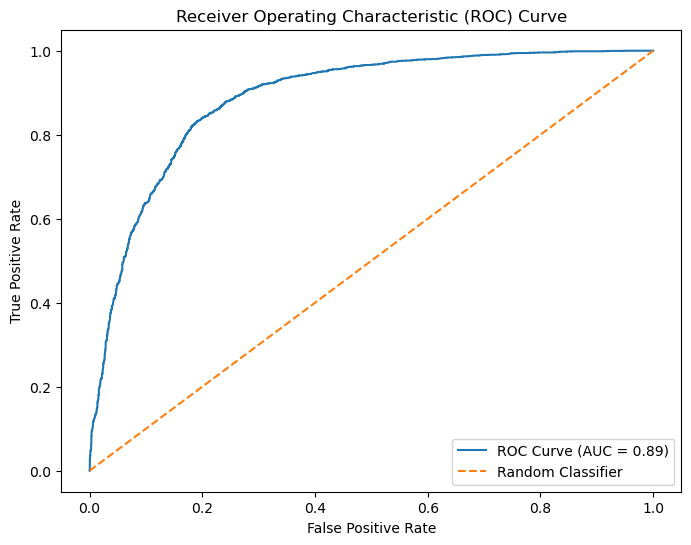


******************** Analysis for Logistic Regression ********************
Accuracy: 0.7734
Best hyperparameters: {'C': 0.0003586928655179008}


Re-training model with Best Params
Model training time: 1.130 seconds
Prediction time: 0.025 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      2242
           1       0.76      0.83      0.79      2180

    accuracy                           0.79      4422
   macro avg       0.79      0.79      0.79      4422
weighted avg       0.79      0.79      0.79      4422

Accuracy: 0.7863
Precision: 0.7887
Recall: 0.7863
F1-score: 0.7860


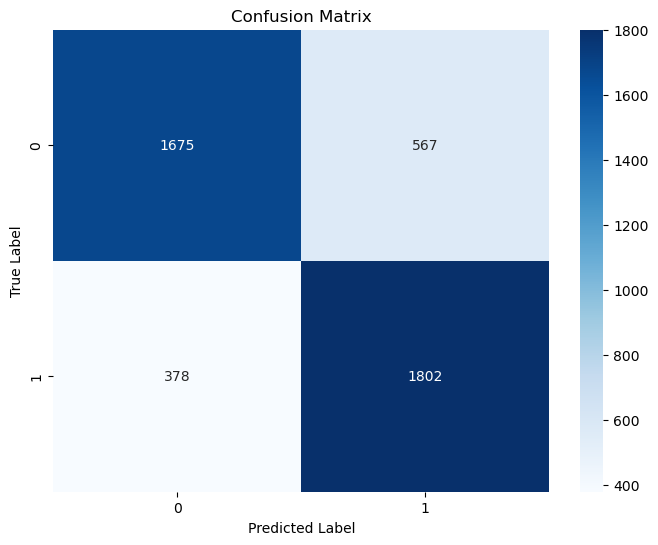

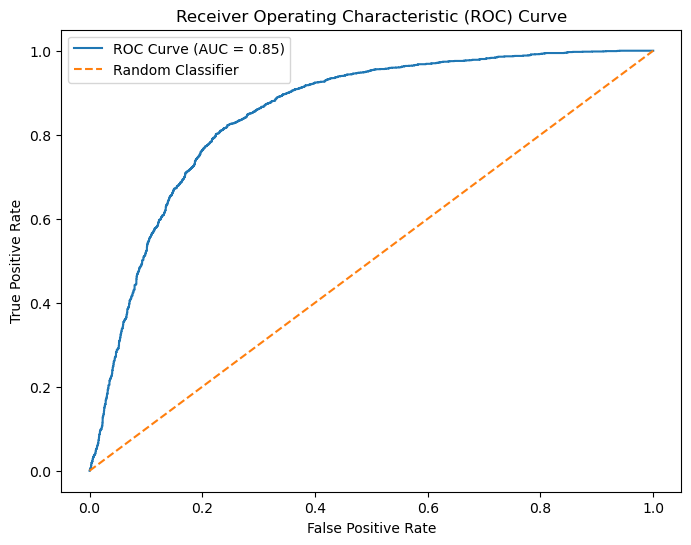


******************** Analysis for Decision Tree ********************
Accuracy: 0.8148
Best hyperparameters: {'max_depth': 16, 'min_samples_split': 9}


Re-training model with Best Params
Model training time: 0.178 seconds
Prediction time: 0.003 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      2242
           1       0.81      0.84      0.82      2180

    accuracy                           0.82      4422
   macro avg       0.82      0.82      0.82      4422
weighted avg       0.82      0.82      0.82      4422

Accuracy: 0.8207
Precision: 0.8212
Recall: 0.8207
F1-score: 0.8207


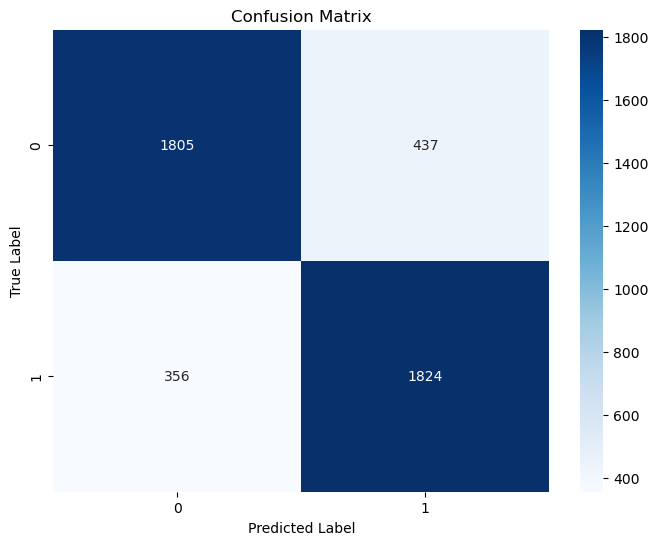

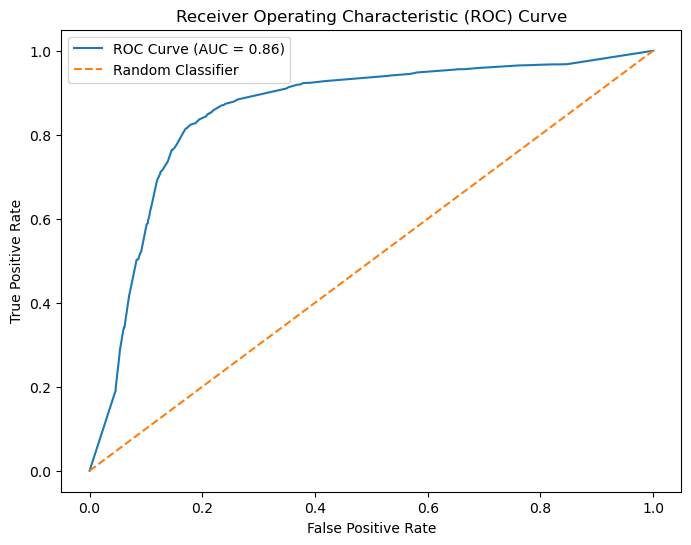


******************** Analysis for Random Forest ********************
Accuracy: 0.7923
Best hyperparameters: {'n_estimators': 169, 'max_depth': 32, 'min_samples_split': 9}


Re-training model with Best Params
Model training time: 0.751 seconds
Prediction time: 0.056 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2242
           1       0.79      0.83      0.81      2180

    accuracy                           0.81      4422
   macro avg       0.81      0.81      0.81      4422
weighted avg       0.81      0.81      0.81      4422

Accuracy: 0.8096
Precision: 0.8105
Recall: 0.8096
F1-score: 0.8095


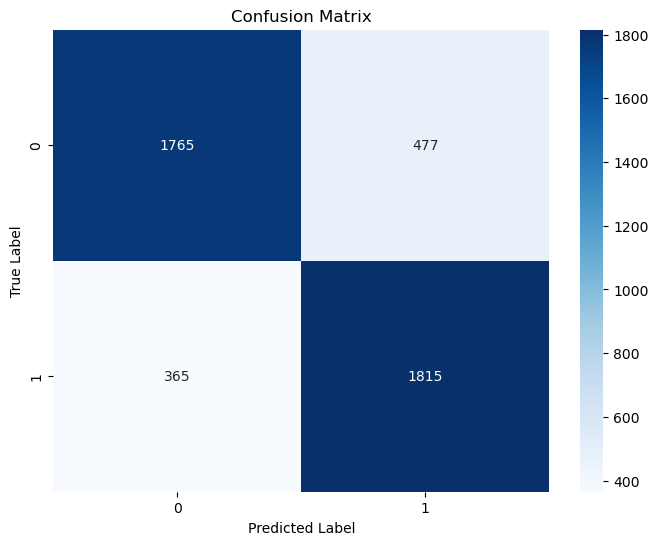

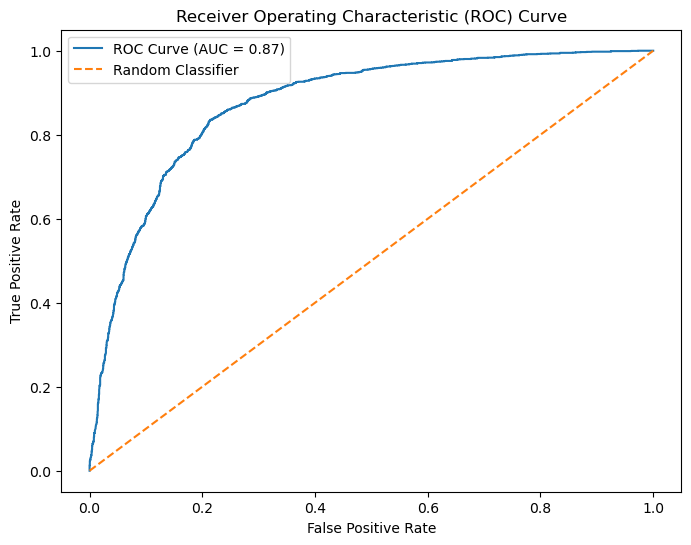

In [41]:
# Print results and plot for each model
model_list = []
for name, study, model in [
                    ("XGB", study_xgb, lr_model), 
                    ("LGBM", study_lgbm, lr_model), 
                    ("Logistic Regression", study_lr, lr_model), 
                    ("Decision Tree", study_dt, dt_model), 
                    ("Random Forest", study_rf, rf_model)]:
    print(f"\n******************** Analysis for {name} ********************")
    print('Accuracy: {:.4f}'.format(study.best_trial.value))
    
    optuna.visualization.plot_optimization_history(study)
    optuna.visualization.plot_slice(study)
    
    best_params = study.best_trial.params
    print("Best hyperparameters: {}".format(best_params))

    print("\n\nRe-training model with Best Params")
    if name == "XGB":
        xgb_model = XGBClassifier(**best_params, n_jobs=-1, seed=42)
        best_xgb_model_new = train_evaluate_model(xgb_model, X_train, X_test, y_train, y_test)
        model_list.append(('xgb', best_xgb_model_new))
    elif name == "LGBM":
        lgbm_model = LGBMClassifier(**best_params, n_jobs=-1, seed=42) 
        best_lgbm_model_new = train_evaluate_model(lgbm_model, X_train, X_test, y_train, y_test)
        model_list.append(('lgbm', best_lgbm_model_new))
    elif name == "Logistic Regression":
        lr_model = LogisticRegression(**best_params, n_jobs = -1, random_state=42)
        best_lr_model_new = train_evaluate_model(lr_model, X_train_1, X_test_1, y_train_1, y_test_1)
        model_list.append(('lr', best_lr_model_new))
    elif name == "Decision Tree":
        dt_model = DecisionTreeClassifier(**best_params, random_state=42)
        best_dt_model_new = train_evaluate_model(dt_model, X_train, X_test, y_train, y_test)
        model_list.append(('dt', best_dt_model_new))
    else:
        rf_model = RandomForestClassifier(**best_params, n_jobs = -1, random_state=42)
        best_rf_model_new = train_evaluate_model(rf_model, X_train, X_test, y_train, y_test)
        model_list.append(('rf', best_rf_model_new))

In [42]:
# Create the VotingClassifier
start_train = time.time()
voting_clf = VotingClassifier(estimators=model_list, voting='hard')

# Train the VotingClassifier
voting_clf.fit(X_train, y_train)
end_train = time.time()
train_time = end_train - start_train

print(f"Model execution time: {train_time:.3f} seconds")

# Make predictions
predictions = voting_clf.predict(X_test)

# Evaluate the model
accuracy = voting_clf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")    

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Info] Number of positive: 8875, number of negative: 8813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 17688, number of used features: 210
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501753 -> initscore=0.007010
[LightGBM] [Info] Start training from score 0.007010
Model execution time: 3.486 seconds
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set